In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print('Setup Completed')

Setup Completed


In [5]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

^C


In [3]:
ls

 Volume in drive C is SSD
 Volume Serial Number is 74F9-96B0

 Directory of C:\Users\gupta\Google Drive\Extracurriculars\Growth Gauge\Growth Gauge- ML Model

09-07-2021  18:48    <DIR>          .
09-07-2021  18:48    <DIR>          ..
25-06-2021  16:53    <DIR>          .ipynb_checkpoints
09-07-2021  04:28        33,623,048 anaemicvsnonanaemic.h5
02-07-2021  08:22        33,623,048 catsvsdogmodel.h5
07-05-2021  15:47             2,114 createDataset.py
23-04-2021  18:18    <DIR>          Dataset
10-05-2021  16:31               629 enterUserInformation.py
10-06-2021  16:54               357 generateGraph.py
10-06-2021  18:18             2,234 generateResult.py
28-06-2021  16:30    <DIR>          kaggle
28-06-2021  16:41       824,894,548 kagglecatsanddogs_3367a.zip
09-07-2021  18:48           773,269 Keras Sequential Example.ipynb
03-07-2021  18:40    <DIR>          MalnutritionImages
02-07-2021  18:44    <DIR>          newModelTestInput
03-07-2021  18:44    <DIR>          newModelTestIn

In [4]:
ls MalnutritionImages

 Volume in drive C is SSD
 Volume Serial Number is 74F9-96B0

 Directory of C:\Users\gupta\Google Drive\Extracurriculars\Growth Gauge\Growth Gauge- ML Model\MalnutritionImages

03-07-2021  18:40    <DIR>          .
03-07-2021  18:40    <DIR>          ..
03-07-2021  06:43    <DIR>          Anaemic
03-07-2021  06:44    <DIR>          Non-Anaemic
               0 File(s)              0 bytes
               4 Dir(s)  122,802,700,288 bytes free


In [5]:
import os

num_skipped = 0

for folder_name in ('Anaemic', 'Non-Anaemic'):
    folder_path = os.path.join("MalnutritionImages", folder_name)
    
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        
        try:
            fobj = open(fpath, 'rb')
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
            
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted corrupted files", num_skipped)

Deleted corrupted files 0


In [6]:
#Generate Dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "MalnutritionImages",
    validation_split = 0.2,
    subset = "training", 
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "MalnutritionImages",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 274 files belonging to 2 classes.
Using 220 files for training.
Found 274 files belonging to 2 classes.
Using 54 files for validation.


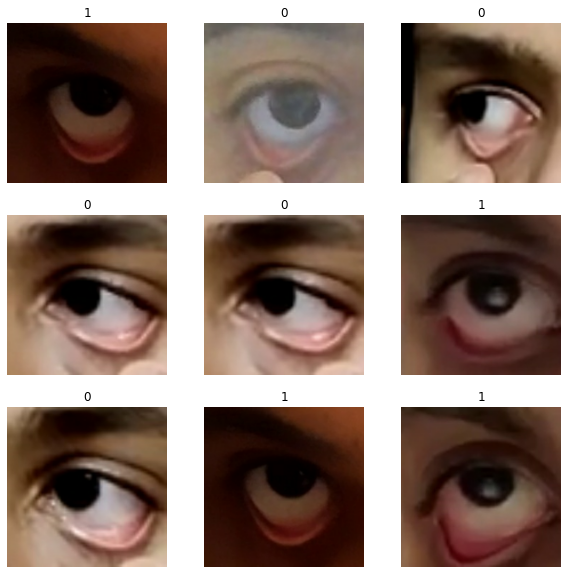

In [7]:
# Visualise Data

import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')
        
plt.show()

In [1]:
#Data Image Augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")
        
plt.show()

NameError: name 'keras' is not defined

In [9]:
#Configuration Of Dataset

train_ds = train_ds.prefetch(buffer_size = 32)
val_ds = val_ds.prefetch(buffer_size = 32)

In [10]:
#Building Machine Learning Model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape = input_shape)
    
    x = data_augmentation(inputs)
    
    x = layers.experimental.preprocessing.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    for size in (128, 256, 512, 728):
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)
        
        residual = layers.Conv2D(size, 1, strides = 2, padding = "same")(previous_block_activation)
        
        x = layers.add([x, residual])
        previous_block_activation = x
    
    x = layers.SeparableConv2D(1024, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "sigmoid"
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation = activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape = image_size+(3,), num_classes = 2)
keras.utils.plot_model(model, show_shapes = True)
    

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
epochs = 400

callbacks = [
    keras.callbacks.ModelCheckpoint("anaemicvsnonanaemic.h5")
]
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

model.fit(
    train_ds, epochs = epochs, callbacks = callbacks, validation_data = val_ds,
)

Epoch 1/400
7/7 [==============================] - 40s 5s/step - loss: 0.2671 - accuracy: 0.8409 - val_loss: 0.6806 - val_accuracy: 0.6296


c:\users\gupta\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/400
7/7 [==============================] - 39s 6s/step - loss: 0.0481 - accuracy: 0.9773 - val_loss: 0.6780 - val_accuracy: 0.6296
Epoch 3/400
7/7 [==============================] - 39s 6s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.6800 - val_accuracy: 0.6296
Epoch 4/400
7/7 [==============================] - 40s 6s/step - loss: 0.0418 - accuracy: 0.9909 - val_loss: 0.6963 - val_accuracy: 0.3704
Epoch 5/400
7/7 [==============================] - 39s 6s/step - loss: 0.0259 - accuracy: 0.9864 - val_loss: 0.7153 - val_accuracy: 0.3704
Epoch 6/400
7/7 [==============================] - 39s 6s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.7283 - val_accuracy: 0.3704
Epoch 7/400
7/7 [==============================] - 39s 6s/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.7579 - val_accuracy: 0.3704
Epoch 8/400
7/7 [==============================] - 40s 6s/step - loss: 9.0921e-04 - accuracy: 1.0000 - val_loss: 0.7884 - val_accuracy: 0.3704
Epoch 9/400
7/7 [======

7/7 [==============================] - 39s 6s/step - loss: 4.8040e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 117/400
7/7 [==============================] - 39s 6s/step - loss: 2.3916e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 118/400
7/7 [==============================] - 39s 6s/step - loss: 3.6803e-04 - accuracy: 1.0000 - val_loss: 6.9698e-04 - val_accuracy: 1.0000
Epoch 119/400
7/7 [==============================] - 39s 6s/step - loss: 1.4277e-04 - accuracy: 1.0000 - val_loss: 4.2721e-04 - val_accuracy: 1.0000
Epoch 120/400
7/7 [==============================] - 38s 6s/step - loss: 8.1702e-05 - accuracy: 1.0000 - val_loss: 3.1004e-04 - val_accuracy: 1.0000
Epoch 121/400
7/7 [==============================] - 39s 6s/step - loss: 7.7120e-05 - accuracy: 1.0000 - val_loss: 2.3930e-04 - val_accuracy: 1.0000
Epoch 122/400
7/7 [==============================] - 39s 6s/step - loss: 2.8208e-05 - accuracy: 1.0000 - val_loss: 1.9370e-04 - 

7/7 [==============================] - 39s 6s/step - loss: 5.5510e-06 - accuracy: 1.0000 - val_loss: 3.7472e-06 - val_accuracy: 1.0000
Epoch 227/400
7/7 [==============================] - 39s 6s/step - loss: 8.8699e-06 - accuracy: 1.0000 - val_loss: 3.5820e-06 - val_accuracy: 1.0000
Epoch 228/400
7/7 [==============================] - 39s 6s/step - loss: 5.9325e-06 - accuracy: 1.0000 - val_loss: 3.4378e-06 - val_accuracy: 1.0000
Epoch 229/400
7/7 [==============================] - 38s 6s/step - loss: 8.1308e-06 - accuracy: 1.0000 - val_loss: 3.3426e-06 - val_accuracy: 1.0000
Epoch 230/400
7/7 [==============================] - 39s 6s/step - loss: 6.9820e-06 - accuracy: 1.0000 - val_loss: 3.2172e-06 - val_accuracy: 1.0000
Epoch 231/400
7/7 [==============================] - 39s 6s/step - loss: 1.1649e-05 - accuracy: 1.0000 - val_loss: 3.1532e-06 - val_accuracy: 1.0000
Epoch 232/400
7/7 [==============================] - 39s 6s/step - loss: 4.4233e-06 - accuracy: 1.0000 - val_loss: 3.083

7/7 [==============================] - 39s 6s/step - loss: 1.1442e-05 - accuracy: 1.0000 - val_loss: 1.5034e-06 - val_accuracy: 1.0000
Epoch 282/400
7/7 [==============================] - 39s 6s/step - loss: 7.8576e-06 - accuracy: 1.0000 - val_loss: 1.4769e-06 - val_accuracy: 1.0000
Epoch 283/400
7/7 [==============================] - 39s 6s/step - loss: 3.1409e-05 - accuracy: 1.0000 - val_loss: 1.5269e-06 - val_accuracy: 1.0000
Epoch 284/400
7/7 [==============================] - 39s 6s/step - loss: 4.9269e-06 - accuracy: 1.0000 - val_loss: 1.8727e-06 - val_accuracy: 1.0000
Epoch 285/400
7/7 [==============================] - 39s 6s/step - loss: 4.8378e-06 - accuracy: 1.0000 - val_loss: 2.0393e-06 - val_accuracy: 1.0000
Epoch 286/400
7/7 [==============================] - 39s 6s/step - loss: 4.8612e-06 - accuracy: 1.0000 - val_loss: 2.1001e-06 - val_accuracy: 1.0000
Epoch 287/400
7/7 [==============================] - 39s 6s/step - loss: 5.7162e-06 - accuracy: 1.0000 - val_loss: 2.115

7/7 [==============================] - 39s 6s/step - loss: 1.0965e-05 - accuracy: 1.0000 - val_loss: 7.7812e-07 - val_accuracy: 1.0000
Epoch 337/400
7/7 [==============================] - 39s 6s/step - loss: 2.4519e-06 - accuracy: 1.0000 - val_loss: 7.8704e-07 - val_accuracy: 1.0000
Epoch 338/400
7/7 [==============================] - 39s 6s/step - loss: 9.0918e-06 - accuracy: 1.0000 - val_loss: 8.0235e-07 - val_accuracy: 1.0000
Epoch 339/400
7/7 [==============================] - 39s 6s/step - loss: 3.3417e-06 - accuracy: 1.0000 - val_loss: 8.2414e-07 - val_accuracy: 1.0000
Epoch 340/400
7/7 [==============================] - 39s 6s/step - loss: 2.8387e-06 - accuracy: 1.0000 - val_loss: 8.4078e-07 - val_accuracy: 1.0000
Epoch 341/400
7/7 [==============================] - 39s 6s/step - loss: 6.2929e-06 - accuracy: 1.0000 - val_loss: 8.6586e-07 - val_accuracy: 1.0000
Epoch 342/400
7/7 [==============================] - 39s 6s/step - loss: 6.9132e-06 - accuracy: 1.0000 - val_loss: 8.884

In [13]:
import matplotlib.pyplot as plt

# print(model.fit.history.key())
plt.plot(model.fit['accuracy'])
plt.plot(model.fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model.fit.history['loss'])
plt.plot(model.fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


TypeError: 'method' object is not subscriptable